In [71]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [72]:
import numpy as np
import pandas as pd

In [73]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [74]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [75]:
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [76]:
station_data_db = pd.read_sql("SELECT * FROM station", conn)
station_data_db

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [77]:
measurement_data_db = pd.read_sql("SELECT * FROM measurement", conn)
measurement_data_db

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [78]:
# reflect an existing database into a new model

# generate classes
Base = automap_base()
Base.prepare(engine, reflect=True)


In [79]:
# We can view all of the classes that automap found
for entry in Base.classes:
    print(entry)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [80]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [81]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

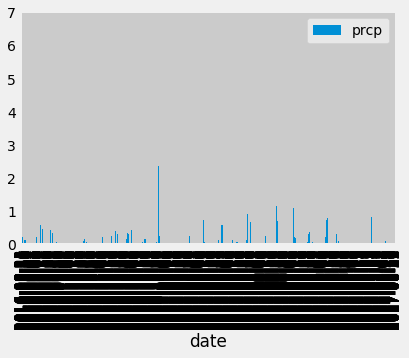

In [148]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
from datetime import datetime 

# Calculate last data point in database
max_date_result = session.query(Measurement,func.max(Measurement.date))
max_date = max_date_result[0].measurement.date
max_date = datetime.strptime(max_date,"%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
min_date = max_date - dt.timedelta(days=366)
min_date = datetime.strftime(min_date, "%Y-%m-%d")

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data = pd.read_sql("SELECT date, prcp FROM measurement WHERE date > '" + min_date + "'", conn)
#precip_data = precip_data.set_index('date')
precip_data

# Sort the dataframe by date
precip_data = precip_data.sort_values(by='date')
precip_data

# Use Pandas Plotting with Matplotlib to plot the data
precip_data.plot.bar(x="date", y="prcp")

In [92]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_data.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [94]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [107]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).all()
active_station_df = pd.read_sql("SELECT station, count(*) AS num_reports FROM Measurement GROUP BY station ORDER BY num_reports DESC", conn)
active_station_df

,station,num_reports
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [111]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519397').all()


[(87.0, 56.0, 74.55323054331865)]

In [145]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Since no station had rows not containing tobs, this was calculated by station with most rows.
max_date_station_result = session.query(func.max(Measurement.date)).filter(Measurement.station == 'USC00519281').first()
max_date_station = datetime.strptime(max_date_station_result[0], '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
min_date_station = max_date_station - dt.timedelta(days=366)
min_date_station_string = datetime.strftime(min_date_station, "%Y-%m-%d") 
most_observations_df = pd.read_sql("SELECT date, tobs FROM Measurement WHERE station = 'USC00519281' AND date > '" + min_date_station_string + "'", conn)

most_observations_df = most_observations_df.sort_values('date')
most_observations_df = most_observations_df.set_index('date')
most_observations_df

,tobs
date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000217C5E97708>]],
      dtype=object)

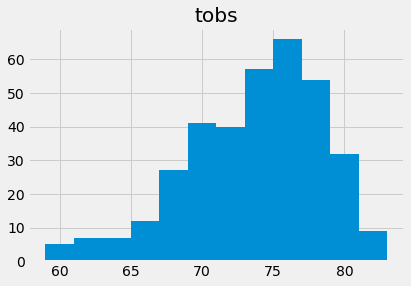

In [146]:
most_observations_df.hist(bins = 12)

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
